# Improving the wet bulb temperature calculation

Thomas Schanzer z5310829  
School of Physics, UNSW  
November 2021

**Romps (2017), *Exact Expression for the Lifting Condensation Level*** finds that there is an analytical solution for LCL pressure and temperature. We can use this in Normand's rule to calculate the wet bulb temperature without problematic systematic errors. In this notebook, we implement the calculation and compare it to the results from Davies-Jones (2008) and MetPy in terms of accuracy and speed.

In [118]:
import numpy as np
from scipy.special import lambertw

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.units import units

import sys
sys.path.append('../scripts/')
from thermo import moist_lapse, wetbulb, theta_e

## Implementation

In [113]:
def lcl_romps(p, T, q):
    """
    Analytic solution for the LCL (adapted from Romps 2017).
    
    This code is adapted from Romps (2017):
    https://romps.berkeley.edu/papers/pubdata/2016/lcl/lcl.py
    
    Args:
        p: Pressure.
        T: Temperature.
        q: Specific humidity.
        
    Returns:
        (pressure, temperature) at the LCL.
    """
    
    # unit conversions
    rhl = mpcalc.relative_humidity_from_specific_humidity(p, T, q).m
    p = p.m_as(units.pascal)
    T = T.m_as(units.kelvin)
    
    # Parameters
    Ttrip = 273.16     # K
    ptrip = 611.65     # Pa
    E0v   = 2.3740e6   # J/kg
    ggr   = 9.81       # m/s^2
    rgasa = 287.04     # J/kg/K 
    rgasv = 461        # J/kg/K 
    cva   = 719        # J/kg/K
    cvv   = 1418       # J/kg/K 
    cvl   = 4119       # J/kg/K 
    cvs   = 1861       # J/kg/K 
    cpa   = cva + rgasa
    cpv   = cvv + rgasv

    # The saturation vapor pressure over liquid water
    def pvstarl(T):
        return (ptrip * (T/Ttrip)**((cpv-cvl)/rgasv)
            * np.exp((E0v - (cvv-cvl)*Ttrip) / rgasv * (1/Ttrip - 1/T)))
   
    # Calculate pv from rh, rhl, or rhs
    pv = rhl * pvstarl(T)

    # Calculate lcl_liquid and lcl_solid
    qv = rgasa*pv / (rgasv*p + (rgasa-rgasv)*pv)
    rgasm = (1-qv)*rgasa + qv*rgasv
    cpm = (1-qv)*cpa + qv*cpv
    aL = -(cpv-cvl)/rgasv + cpm/rgasm
    bL = -(E0v-(cvv-cvl)*Ttrip)/(rgasv*T)
    cL = rhl*np.exp(bL)
    T_lcl = bL/(aL*lambertw(bL/aL*cL**(1/aL),-1).real)*T
    p_lcl = p*(T_lcl/T)**(cpm/rgasm)

    return p_lcl/1e2*units.mbar, T_lcl*units.kelvin

In [ ]:
%%timeit
lcl_romps(900*units.mbar, 10*units.celsius, 5e-3)

1.78 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
lcl_metpy(900*units.mbar, 10*units.celsius, 5e-3)

9.76 ms ± 95.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
def wetbulb_romps(pressure, temperature, specific_humidity):
    """
    Calculates wet bulb temperature using Normand's rule and Romps (2017).
    
    Args:
        p: Pressure.
        T: Temperature.
        q: Specific humidity.
        
    Returns:
        Wet bulb temperature.
    """
    
    lcl_pressure, lcl_temperature = lcl(
        pressure, temperature, specific_humidity)
    return moist_lapse(pressure, lcl_temperature, lcl_pressure)

In [130]:
%%timeit
wetbulb_romps(900*units.mbar, 10*units.celsius, 5e-3)

32.1 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [124]:
%%timeit
wetbulb(900*units.mbar, 10*units.celsius, theta_e(900*units.mbar, 10*units.celsius, 5e-3))

5.35 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [131]:
%%timeit
mpcalc.wet_bulb_temperature(
    900*units.mbar, 10*units.celsius,
    mpcalc.dewpoint_from_specific_humidity(
        900*units.mbar, 10*units.celsius, 5e-3))

42.3 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Testing

In [119]:
pressure = np.arange(1000, 199, -50)*units.mbar
temperature = np.arange(-30, 31, 3)*units.celsius
P, T = np.meshgrid(pressure, temperature)
q_30 = mpcalc.specific_humidity_from_mixing_ratio(
    mpcalc.mixing_ratio_from_relative_humidity(P, T, 0.3))
q_50 = mpcalc.specific_humidity_from_mixing_ratio(
    mpcalc.mixing_ratio_from_relative_humidity(P, T, 0.5))
q_70 = mpcalc.specific_humidity_from_mixing_ratio(
    mpcalc.mixing_ratio_from_relative_humidity(P, T, 0.7))
q_90 = mpcalc.specific_humidity_from_mixing_ratio(
    mpcalc.mixing_ratio_from_relative_humidity(P, T, 0.9))
dewpoint_30 = mpcalc.dewpoint_from_relative_humidity(T, 0.3)
dewpoint_50 = mpcalc.dewpoint_from_relative_humidity(T, 0.5)
dewpoint_70 = mpcalc.dewpoint_from_relative_humidity(T, 0.7)
dewpoint_90 = mpcalc.dewpoint_from_relative_humidity(T, 0.9)

In [140]:
%%time
wetbulb_romps_30 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_romps_30[i,ii] = wetbulb_romps(
            pressure[ii], temperature[i], q_30[i,ii]).m
wetbulb_romps_30 = wetbulb_romps_30*units.kelvin

wetbulb_romps_50 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_romps_50[i,ii] = wetbulb_romps(
            pressure[ii], temperature[i], q_50[i,ii]).m
wetbulb_romps_50 = wetbulb_romps_50*units.kelvin

wetbulb_romps_70 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_romps_70[i,ii] = wetbulb_romps(
            pressure[ii], temperature[i], q_70[i,ii]).m
wetbulb_romps_70 = wetbulb_romps_70*units.kelvin

wetbulb_romps_90 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_romps_90[i,ii] = wetbulb_romps(
            pressure[ii], temperature[i], q_90[i,ii]).m
wetbulb_romps_90 = wetbulb_romps_90*units.kelvin

CPU times: user 47.3 s, sys: 483 ms, total: 47.8 s
Wall time: 51.7 s


In [170]:
%%time
wetbulb_dj_30 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_dj_30[i,ii] = wetbulb(
            P[i,ii], theta_e(P[i,ii], T[i,ii], q_30[i,ii])).m
wetbulb_dj_30 = wetbulb_dj_30*units.celsius

wetbulb_dj_50 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_dj_50[i,ii] = wetbulb(
            P[i,ii], theta_e(P[i,ii], T[i,ii], q_50[i,ii])).m
wetbulb_dj_50 = wetbulb_dj_50*units.celsius

wetbulb_dj_70 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_dj_70[i,ii] = wetbulb(
            P[i,ii], theta_e(P[i,ii], T[i,ii], q_70[i,ii])).m
wetbulb_dj_70 = wetbulb_dj_70*units.celsius

wetbulb_dj_90 = np.zeros(P.shape)
for i in range(temperature.size):
    for ii in range(pressure.size):
        wetbulb_dj_90[i,ii] = wetbulb(
            P[i,ii], theta_e(P[i,ii], T[i,ii], q_90[i,ii])).m
wetbulb_dj_90 = wetbulb_dj_90*units.celsius

CPU times: user 8.33 s, sys: 20.4 ms, total: 8.35 s
Wall time: 8.39 s


../scripts/thermo.py:290: RuntimeWarning: invalid value encountered in double_scalars
  f = (C/Tw)**3.504 * (1 - es/pressure)**(3.504*nu) * np.exp(-3.504*G)


In [144]:
%%time
wetbulb_metpy_30 = mpcalc.wet_bulb_temperature(P, T, dewpoint_30)
wetbulb_metpy_50 = mpcalc.wet_bulb_temperature(P, T, dewpoint_50)
wetbulb_metpy_70 = mpcalc.wet_bulb_temperature(P, T, dewpoint_70)
wetbulb_metpy_90 = mpcalc.wet_bulb_temperature(P, T, dewpoint_90)

CPU times: user 46.2 s, sys: 536 ms, total: 46.7 s
Wall time: 49.7 s


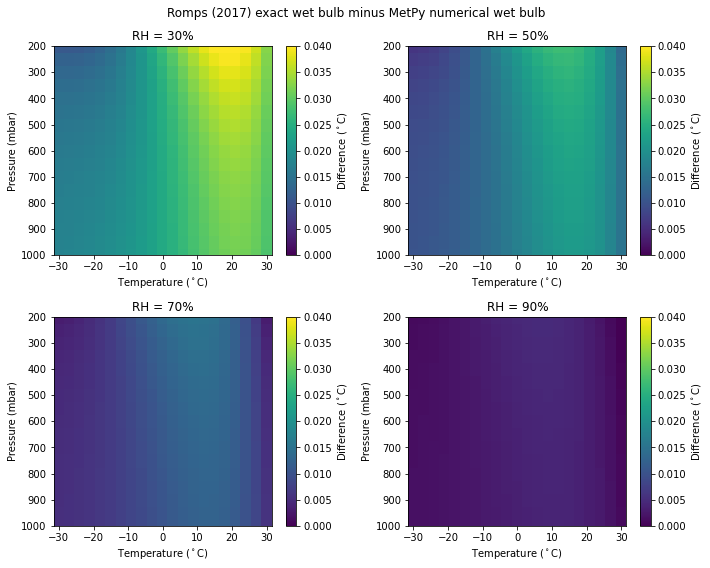

In [167]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(221)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_romps_30 - wetbulb_metpy_30).T, shading='nearest')
mesh.set_clim(0, 0.04)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 30%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

ax = fig.add_subplot(222)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_romps_50 - wetbulb_metpy_50).T, shading='nearest')
mesh.set_clim(0, 0.04)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 50%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

ax = fig.add_subplot(223)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_romps_70 - wetbulb_metpy_70).T, shading='nearest')
mesh.set_clim(0, 0.04)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 70%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

ax = fig.add_subplot(224)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_romps_90 - wetbulb_metpy_90).T, shading='nearest')
mesh.set_clim(0, 0.04)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 90%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

fig.suptitle('Romps (2017) exact wet bulb minus MetPy numerical wet bulb')
fig.tight_layout()

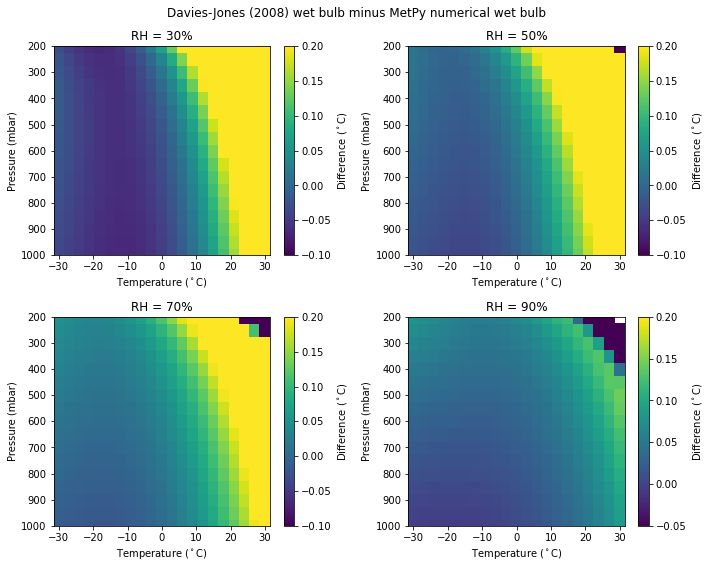

In [177]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(221)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_dj_30 - wetbulb_metpy_30).T, shading='nearest')
mesh.set_clim(-0.1, 0.2)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 30%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

ax = fig.add_subplot(222)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_dj_50 - wetbulb_metpy_50).T, shading='nearest')
mesh.set_clim(-0.1, 0.2)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 50%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

ax = fig.add_subplot(223)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_dj_70 - wetbulb_metpy_70).T, shading='nearest')
mesh.set_clim(-0.1, 0.2)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 70%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

ax = fig.add_subplot(224)
mesh = ax.pcolormesh(T.T, P.T, (wetbulb_dj_90 - wetbulb_metpy_90).T, shading='nearest')
mesh.set_clim(-0.05, 0.2)
cbar = plt.colorbar(mesh)
ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='RH = 90%')
cbar.set_label('Difference ($^\circ$C)')
ax.set_ylim(1000, 200)

fig.suptitle('Davies-Jones (2008) wet bulb minus MetPy numerical wet bulb')
fig.tight_layout()